# Unsupervised Learning with Scikit-Learn
Now we'll work through an example of _unsupervised learning_. Recall unsupervised learning deals with situations in which we have know information on what the labels are, i.e. we're given only the inputs in our dataset. Unsupervised learning is essentially an umbrella term that covers three different tasks. One task is _dimensionality reduction_, where we seek to reduce the dimension of our dataset. The reasons we may wish to do something like this include reducing the memory load of the data, trying to eliminate noise from the data, or trying to visualize high-dimensional data. Another task of unsupervised learning is _clustering_. Clustering involves trying to find underlying patterns in the input data, and using these patterns to infer what our unknown labels are. The last task of unsupervised learning is _density estimation_, i.e. inferring what the underlying joint distribution of the data is.

In this example we use Scikit-Learn illustrate the first two tasks on a real dataset. To begin we load some Python libraries we'll need. As always we need `numpy`, `matplotlib`, and various classes from `sklearn`. We also use the `pandas` library, a very useful library for data processing, to load in the data from an internet `csv` file. The `scipy` library is used to perform hierarchical clustering later on since it is able to show tree plots. As usual, we also set a random seed to allow for replication of our results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import preprocessing
np.random.seed(42)

Next, we define several support functions that will be used. The first function loads in our input data and returns it as the usual array. The rest generate various plots that we'll talk about in more detail.

In [2]:
def get_data(dataset):
    if dataset==1:
        names = ['x'+str(i) for i in range(1,3+1)]
        df = pd.read_csv('http://www.apps.stat.vt.edu/leman/VTCourses/ClusterSet1.txt',
                         delim_whitespace=True,header=None,names=names)
    elif dataset==2:
        names = ['x'+str(i) for i in range(1,50+1)]
        df = pd.read_csv('http://www.apps.stat.vt.edu/leman/VTCourses/ClusterSet2.txt',
                         delim_whitespace=True,header=None,names=names)
    X = preprocessing.scale(df.values)
    return X
    
def pca_plot(X):
    N = min(X.shape[1],20)
    pca = PCA(n_components=N)
    pca.fit(X)
    plt.plot(range(1,N+1),pca.explained_variance_ratio_)
    plt.xlim(0,N+1)
    plt.xticks(np.arange(1,N+1))
    plt.xlabel('principal components')
    plt.ylabel('% of variance explained')
    plt.show()

def loss_plot(X,model_type='k-means',max_clusters=10):
    num_clusters = np.arange(1,max_clusters+1)
    scores = []
    for num in num_clusters:
        if model_type=='k-means':
            model = KMeans(n_clusters=num)
        elif model_type=='GMM':
            model = GaussianMixture(n_components=num, covariance_type='full')
        elif model_type=='BGMM':
            model = BayesianGaussianMixture(n_components=num, covariance_type='full')
        model.fit(X)
        scores += [-model.score(X)]        
    plt.plot(np.arange(1,max_clusters+1),scores)
    plt.xlim(0,max_clusters)
    plt.xticks(np.arange(1,max_clusters+1))
    plt.xlabel('number of clusters')
    plt.ylabel('loss')
    plt.title(model_type+' loss plot')
    plt.show()

def plot_clusters(X,y,model_type):
    color_iter = ['blue','red','green','darkorange','yellow','cyan','brown',
                  'purple','pink','black']
    num_clusters = np.unique(y).shape[0]
    for i in range(num_clusters):
        if not np.any(y == i):
            continue
        plt.scatter(X[y == i, 0], X[y == i, 1], .8, color=color_iter[i])
    plt.title(model_type+': '+str(num_clusters)+' clusters')
    plt.show()

Now we get to the machine learning. The first thing we will do is dimensionality reduction on our data. The specific reduction algorithm we use is _Principal Components Analysis_, or PCA. This is by far the most widely known reduction algorithm out there. It acts by finding the directions in the feature space that preserve the most variation in the data, ranking those directions in order of importance. In doing dimensionality reduction, or task is to find how many of those directions we should keep to preserve "enough" structure in the data to make us happy. We can do this by plotting the explained variance ratio, and picking enough dimensions to maintain a specified level of variance (usually 90% or above). In our case, we take the top two dimensions, mainly so we can visualize the data.

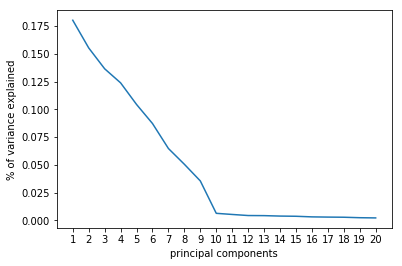

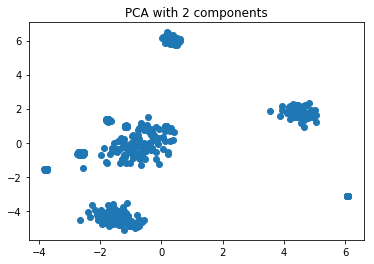

In [3]:
X = get_data(2)

pca_plot(X)

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

plt.scatter(X_pca[:,0],X_pca[:,1])
plt.title('PCA with 2 components')
plt.show()

Now let's do some clustering on our new 2-dimensional dataset. The most popular clustering algorithm is _k-means clustering_, probably the simplest clustering technique out there. k-means clustering acts by using an interative procedure to find the $k$ best local averages in the data. These _centroids_ are then used to determine what clusters the algorithm comes up with. Given a point, to determine what cluster it's in you find its closest centroid and give it the label of that centroid. Of course, the first question you should ask yourself is what value of $k$ you should choose. The algorithm doesn't do this for you, you have to specify it. This is perhaps the algorithm's biggest weakness, because we often don't know how many clusters there really should be in the data. We can find a good value of $k$ similar to what we did with PCA above. The API is then almost identical to the supervised learning APIs we used before.

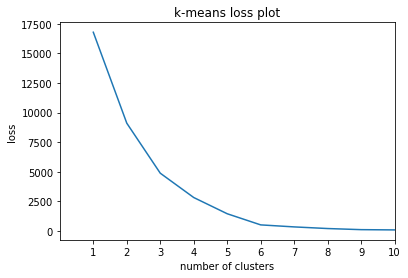

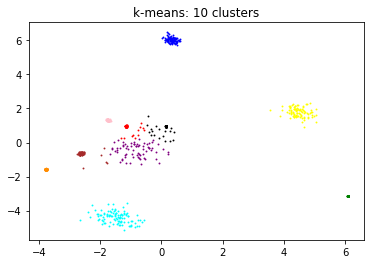

In [4]:
loss_plot(X_pca,model_type='k-means')    
model = KMeans(n_clusters=10)
model.fit(X_pca)
y = model.predict(X_pca)    
plot_clusters(X_pca,y,'k-means')

We finish up by just briefly comparing k-means with some other popular clustering algorithms. I won't go into these in detail. I encourage you to look them up though because you may want to use them at some point.

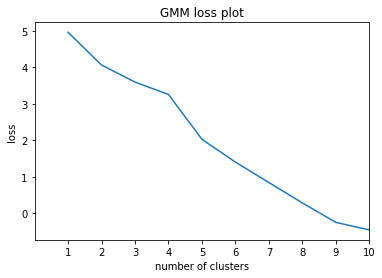

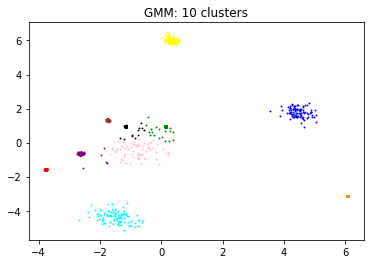

In [6]:
# Gaussian mixtures    
loss_plot(X_pca,model_type='GMM')    
model = KMeans(n_clusters=10)
model.fit(X_pca)
y = model.predict(X_pca)    
plot_clusters(X_pca,y,'GMM')

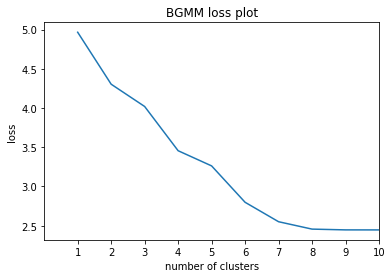

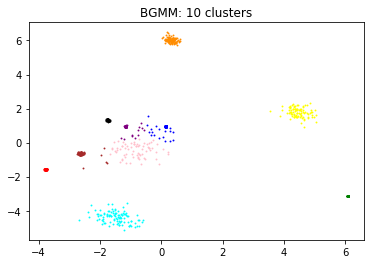

In [7]:
# Bayesian Gaussian mixtures    
loss_plot(X_pca,model_type='BGMM')    
model = KMeans(n_clusters=10)
model.fit(X_pca)
y = model.predict(X_pca)    
plot_clusters(X_pca,y,'BGMM')

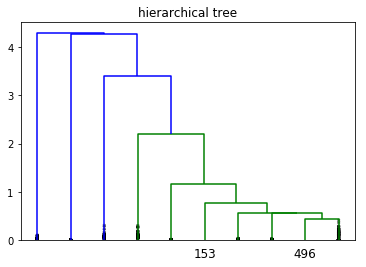

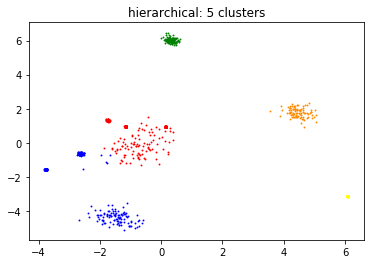

In [8]:
# Hierarchical Clustering    
Z = linkage(X_pca,method='single')
plt.figure()
dn = dendrogram(Z,p=10,truncate_mode='lastp',show_contracted=True,show_leaf_counts=False)
plt.title('hierarchical tree')
plt.show()

model = AgglomerativeClustering(n_clusters=5)
model.fit(X_pca)
y = model.labels_  
plot_clusters(X_pca,y,'hierarchical')
plt.show()

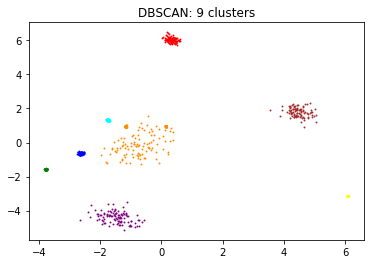

In [9]:
# DBSCAN
model = DBSCAN()
model.fit(X_pca)
y = model.labels_
plot_clusters(X_pca,y,'DBSCAN')
plt.show()